### z2h 1. Intro to NN+backprop: building micrograd

In [225]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

import torch
from torch import Tensor

import random

#from micrograd.engine import Value

micrograd: small autograd engine -- implements backprop+allows you to efficiently evaluate grad of loss fn wrt weights of a NN

- can iteratively tune weights of NN to minimize loss fn+improve accuracy of net
- allows you to build expressions (by wrapping values into value objects)
    - then can tranform the values and perform math operations
    - building out expression graph with inputs $\rightarrow$ create output 
    - any results of value objects in operations $\rightarrow$ also a value object
        - ex. add value objects $a$ and $b$ to get result $c$ (see below)
            - child nodes of $c$ will be $a$ and $b$
            - go through all these operations to output of our forward pass ($g$) -- access value using `.data` attribute
            - then take $g$ and call `.backward()` to initizalize backprop at the node $g$
                - goes backwards through expression graph and recursively apply chain rule
                - can evaluate derivative of g wrt all internal nodes (such as $c$, $d$, $e$) and also inputs ($a$ and $b$)
                - then we can query derivative of $g$ wrt $a$ (`a.grad`), $g$ wrt $b$
                - tells us how $a$ and $b$ are affecting $g$ through mathematical expression
                    - how $g$ will respond if $a$ and $b$ get tweaked a tiny amount in positive direction

In [4]:
#example usage
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a*b + b**3
c += c + 1
c += 1 + c + (-a)
d += d*2 + (b+a).relu()
d += 3*d + (b-a).relu()
e = c - d
f = e**2
g = f/2.0
g += 10.0/f
print(f'{g.data:.4f}') #outcome of forward pass
g.backward()
print(f'{a.grad:.4f}') #num value of dg/da
print(f'{b.grad:.4f}') #dg/db

24.7041
138.8338
645.5773


NN: just a mathematical expression

- input data as an input
- weights of NN as an input
- output: predictions of NN or loss fn
- backprop not specific to NN

micrograd: scalar valued autograd engine; works on levels of individual scalars (normally don't write out every mathematical expression; this is just a demonstration without using tensors)

- normally use tensors; run parallel (faster)

Breaking down code for micrograd (very simple):

- `engine.py`: actual backprop engine (not to do w/ NN)
- `nn.py`: entire NN library; only need to define:
    - what a neuron is
    - layer of neurons
    - multi-layer perceptron (MLP); just a sequence of layers of neurons

In [2]:
#define scalar-valued fn
def f(x):
    """quadratic fn that takes single scalar x, returns single scalar y"""
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

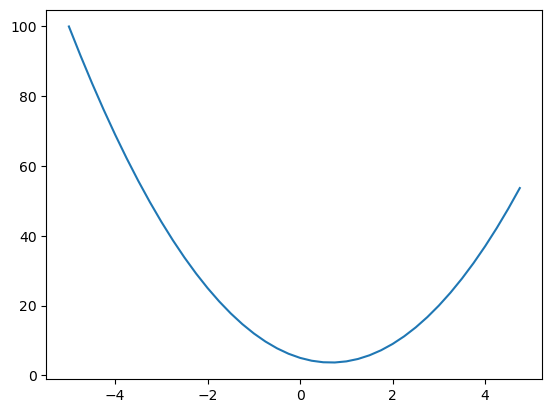

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

What is the derivative of this fn at any single input $x$?

- on paper -- write it out by hand and find derivative
- however NNs too complex for that; just understand what derivative is telling you about this fn
- def derivative: at some point $a$ if you slightly increase it by a small number $h$, how does the fn respond? (w/ what sensitivity; up or down)

Evaluate derivative numerically:

In [5]:
h = 0.00001
x = 3.0
f(x+h) #expected to be slightly greater than 20 aka f(x)

20.0001400003

In [6]:
#slightly greater...by how much? 
f(x+h) - f(x) 
#how much fn responded in the positive direction 

0.0001400003000000538

In [7]:
#normalize by run to get slope (rise/run)
(f(x+h) - f(x))/h

14.00003000000538

can make $h$ smaller and smaller to converge to the exact amount, but at some point we'll get incorrect answer (0) b/c representation of these numbers in computer memory is finite

In [8]:
#slope at x=-3
x = -3.0
(f(x+h) - f(x))/h

-21.999970000052823

if we take the slope at $x=-3$, expect something negative

at some point, slope will be 0 (for this fn, at $x=2/3$)

In [9]:
#slope at x=2/3
x = 2/3
(f(x+h) - f(x))/h
#nudge in positive direction -> fn doesn't respond

3.0000002482211127e-05

Now a more complex example:

In [10]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


slope below will be $d_2-d_1$ -- how much fn increased when we bump the specific input we're interested in by a tiny amount; then normalized by $h$

In [11]:
#look at derivatives of d wrt a, b, c
h = 0.0001

#fix inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

#derivative of d wrt a
a += h #bump a by h -- a is slightly more positive
d2 = a*b + c #b is negative --> expect value of fn to go down

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


we know that the slope is -3 mathematically as well; taking derivative of $ab+c$ will give us $b$, which is -3

In [12]:
#now wrt b
h = 0.0001

#fix inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

#derivative of d wrt b
b += h #bump b by h -- b is slightly more positive
d2 = a*b + c #a is positive --> expect value of fn to go up

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


above, slope is 2 b/c derivative wrt $b$ is $a$, which is 2

In [13]:
#now wrt c
h = 0.0001

#fix inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

#derivative of d wrt c
c += h #bump c by h -- value will go up by the exact smae amount we added to c
d2 = a*b + c #d will increase by scale of 1 when this happens

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


moving to NN -- massive expressions, so we need data structures to maintain expressions

built out value object

In [14]:
#simple value object skeleton
class Value:
    """wraps+tracks a single scalar value"""
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"

Create Value objects:

In [16]:
a = Value(2.0)
b = Value(-3.0)
a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

Returns TypeError b/c Python doesn't know how to add 2 value objects

Tell it how using double underscores to define operators:

In [20]:
#defining some operators
class Value:
    """wraps+tracks a single scalar value"""
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        """print out nicer looking expression; actual value of the object"""
        return f"Value(data={self.data})"
    
    #returns a new object that represents the sum of two objects
    def __add__(self, other):
        """returns new value obj wrapping sum of the data float points"""
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data)
        return out

In [25]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b + c

#equivalent to (manually):
#(a.__mul__(b)).__add__(c)

Value(data=4.0)

Still missing "connective tissue" of this expression; want pointers to show what values produce other values (want to keep expression graphs)

When creating a value obj through addition or multiplication, feed in children of this value object (`self` and `other`)

In [34]:
class Value:
    #adding children (by default an empty tuple)
    """wraps+tracks a single scalar value; """
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children) #empty set if unspecified
    
    def __repr__(self):
        """print out nicer looking expression; actual value of the object"""
        return f"Value(data={self.data})"
    
    #children of value obj created through addition should be self and other
    def __add__(self, other):
        """returns new value obj wrapping sum of the data float points"""
        out = Value(self.data + other.data, (self, other))
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other))
        return out

In [35]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

In [37]:
d._prev
#outputs value -6 (value resulting from a*b), value 10 (resulting from c)

{Value(data=-6.0), Value(data=10.0)}

We now know children that created this value object, but not the operation

new parameter `_op`

In [38]:
class Value:
    #want to track operation, not just children that create the value object
    """wraps+tracks a single scalar value; """
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children) #empty set if unspecified
        self._op = _op
    
    def __repr__(self):
        """print out nicer looking expression; actual value of the object"""
        return f"Value(data={self.data})"
    
    #children of value obj created through addition should be self and other
    def __add__(self, other):
        """returns new value obj wrapping sum of the data float points"""
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out

In [39]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

Visualizing this expression graph

In [68]:
def trace(root):
    """enumerates vertices/edges; build set of all vertices+edges in graph"""
    vertices, edges = set(), set()
    def build(vertex):
        if vertex not in vertices:
            vertices.add(vertex)
            for child in vertex._prev:
                edges.add((child, vertex))
                build(child)
    build(root)
    return vertices, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR = left to right

    vertices, edges = trace(root)
    for vertex in vertices:
        vertex_id = str(id(vertex))
        #creating a record node for any value in graph
        dot.node(name=vertex_id, label="{ data %.4f }" % (vertex.data, ), shape='record')
        #if it's a result of some operation, create an op node for it
        if vertex._op:
             dot.node(name = vertex_id + vertex._op, label = vertex._op)
             #connect to this vertex
             #create edge
             dot.edge(vertex_id + vertex._op, vertex_id)
    
    for vertex_1, vertex_2 in edges:
        #connect vertex 1 to op node of vertex 2
        dot.edge(str(id(vertex_1)), str(id(vertex_2)) + vertex_2._op)

    return dot


can call `draw_dot` on some root vertex (such as $d$)

from left to right:
- we get $a*b$ creating an integrated value (-6)
- plus $c$ gives us output $d$ (4)
- rectangles are actual objects (connect op nodes -- not actual nodes)

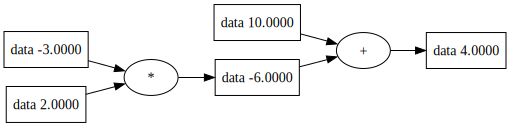

In [69]:
draw_dot(d)

In [70]:
class Value:
    #add labels to graph
    """wraps+tracks a single scalar value; """
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) #empty set if unspecified
        self._op = _op
        self.label = label
    
    def __repr__(self):
        """print out nicer looking expression; actual value of the object"""
        return f"Value(data={self.data})"
    
    #children of value obj created through addition should be self and other
    def __add__(self, other):
        """returns new value obj wrapping sum of the data float points"""
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out

In [71]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e + c; d.label="d"
d

Value(data=4.0)

In [72]:
#modify to include labels
def trace(root):
    """enumerates vertices/edges; build set of all vertices+edges in graph"""
    vertices, edges = set(), set()
    def build(vertex):
        if vertex not in vertices:
            vertices.add(vertex)
            for child in vertex._prev:
                edges.add((child, vertex))
                build(child)
    build(root)
    return vertices, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR = left to right

    vertices, edges = trace(root)
    for vertex in vertices:
        vertex_id = str(id(vertex))
        #creating a record node for any value in graph
        dot.node(name=vertex_id, label="{ %s | data %.4f }" % (vertex.label, vertex.data), shape='record')
        #if it's a result of some operation, create an op node for it
        if vertex._op:
             dot.node(name = vertex_id + vertex._op, label = vertex._op)
             #connect to this vertex
             #create edge
             dot.edge(vertex_id + vertex._op, vertex_id)
    
    for vertex_1, vertex_2 in edges:
        #connect vertex 1 to op node of vertex 2
        dot.edge(str(id(vertex_1)), str(id(vertex_2)) + vertex_2._op)

    return dot

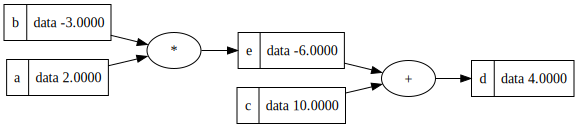

In [73]:
draw_dot(d)

Making expression 1 layer deeper

In [77]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

e = a*b; e.label="e"
#d no longer output
d = e + c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L" #output
L

Value(data=-8.0)

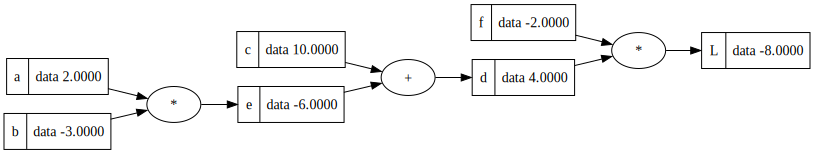

In [78]:
draw_dot(L)

So far, build out mathematical expressions (scalar valued) using addition and multiplication that produces a single output

- multiple inputs: $a$, $b$, $c$, $f$

above: visualizing output of the forward pass (-8); want to also run backprop

- start at the end (at $L$) and reverse/calculate gradient along all intermediate values
- compute derivative of $L$ wrt each of those nodes 

start at $L$; derivative wrt itself is 1 ($\frac{dL}{dL} = 1$)

- then wrt $f$, $d$, $c$, etc

In NN setting: interested in finding derivative of a loss fn $L$ wrt weights of NN  (leaf nodes)

- other leaf nodes: the data itself
    - data is fixed, so don't want derivative wrt data (whereas weights are iterative)

Make a variable `grad` that is initially 0 (no effect)

- assume that this variable does not impact loss fn

In [92]:
class Value:
    #adding a new variable: grad
    """wraps+tracks a single scalar value; """
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) #empty set if unspecified
        self._op = _op
        self.label = label
    
    def __repr__(self):
        """print out nicer looking expression; actual value of the object"""
        return f"Value(data={self.data})"
    
    #children of value obj created through addition should be self and other
    def __add__(self, other):
        """returns new value obj wrapping sum of the data float points"""
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out

In [93]:
#modify to include grad
def trace(root):
    """enumerates vertices/edges; build set of all vertices+edges in graph"""
    vertices, edges = set(), set()
    def build(vertex):
        if vertex not in vertices:
            vertices.add(vertex)
            for child in vertex._prev:
                edges.add((child, vertex))
                build(child)
    build(root)
    return vertices, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) #LR = left to right

    vertices, edges = trace(root)
    for vertex in vertices:
        vertex_id = str(id(vertex))
        #creating a record node for any value in graph
        dot.node(name=vertex_id, label="{ %s | data %.4f | grad %.4f }" % (vertex.label, vertex.data, vertex.grad), shape='record')
        #if it's a result of some operation, create an op node for it
        if vertex._op:
             dot.node(name = vertex_id + vertex._op, label = vertex._op)
             #connect to this vertex
             #create edge
             dot.edge(vertex_id + vertex._op, vertex_id)
    
    for vertex_1, vertex_2 in edges:
        #connect vertex 1 to op node of vertex 2
        dot.edge(str(id(vertex_1)), str(id(vertex_2)) + vertex_2._op)

    return dot

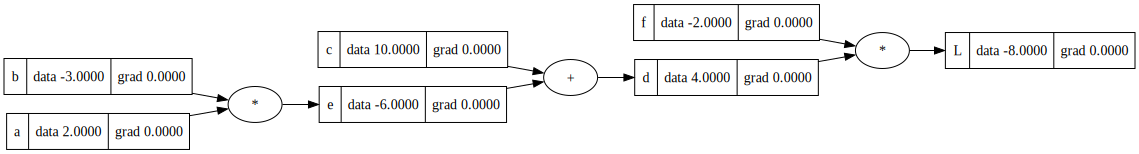

In [122]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d = e + c; d.label="d"
f = Value(-2.0, label="f")
L = d*f; L.label="L" #output

draw_dot(L)

Above: grad label shows derivative of $L$ wrt that specific vertex (e.g. wrt $c$)

Now fill in gradients -- starting from the root:

- derivative of $L$ wrt $L$: if we change $L$ by a little bit in the positive direction ($h$), how much will $L$ change? 

    - proportional -- changes by $h$
    - derivative is 1

some examples:

In [97]:
#gating fn -- avoid polluting global scope (like a staging area)

def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data #this is a float since L is a value object

    #measuring derivative of L wrt a (bumping a)
    a = Value(2.0 + h, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol() #output: derivative of L wrt h = 6

6.000000000000227


In [98]:
#now change L by a small positive amount (h)

def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data #this is a float since L is a value object

    #measuring derivative of L wrt L (bumping L)
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data + h

    print((L2 - L1)/h)

lol() #output: derivative of L wrt L = 1 ("base case")

1.000000000000334


Manual backprop -- set `L.grad` to 1

In [129]:
L.grad = 1.0

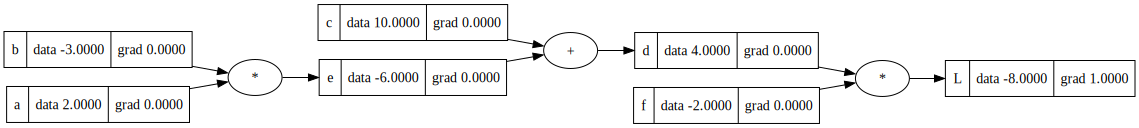

In [100]:
#redraw graph
draw_dot(L)

Now for derivative of $L$ wrt $d$ and $f$

wrt $d$ -- what is $\frac{dL}{dd}$? = $f$

to write it out:

- def of derivative -- $lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$
- $\frac{d*f+h*f-d*f}{h}$
- $\frac{h*f}{h}$
- $=f$

In [128]:
f.grad = 4.0 #value of d
d.grad = -2.0 #value of f

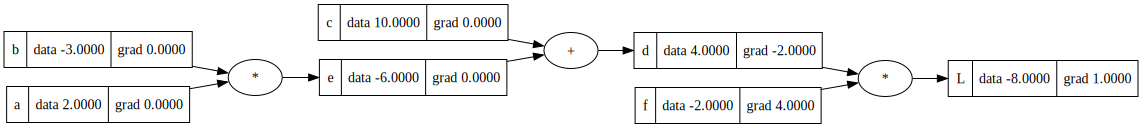

In [103]:
#redraw w/ manually set grad values
draw_dot(L)

In [104]:
#check -- want derivative L wrt f
#now change L by a small positive amount (h)

def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data 

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0 + h, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol() #output: derivative of L wrt f (expect to see 4)

3.9999999999995595


like a gradient check -- deriving backprop + getting derivative w/ respect to all intermediate results

- numerically verify -- numerical gradient: estimate using small step size

In [105]:
#dl/dd

#check -- want derivative L wrt d -- expect to see 2

def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data 

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    d.data += h
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol() #output: derivative of L wrt d (expect to see -2)

-2.000000000000668


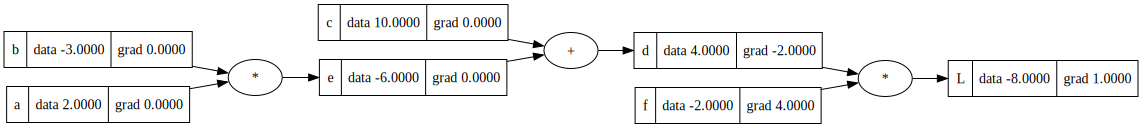

In [106]:
draw_dot(L)

need to find $\frac{dL}{dc}$

- problem: how to derive this?
- what we know: derivative of $L$ wrt $d$
- how is $L$ sensitive to $c$? (if we perturb $c$, how will $L$ respond?)
    - if we know $\frac{dL}{dd}$ and how $c$ impacts $d$, then we should be able to know how $c$ impacts $L$

What is $\frac{dd}{dc}$?

- we know that $d = c+e$ so:
- $\frac{f(x+h)-f(x)}{h}$
- $= \frac{(c+h+e)-(c+e)}{h}$
- $= \frac{h}{h} = 1$
- **local derivative** -- only knows it took $c+e$ (nothing else); embedded in giant graph

How to put this info together? **chain rule**

- def: if a variable $z$ depends on a variable $y$, which itself depends on variable $x$ (they are dependent variables), then $z$ depends on $x$ as well via intermediate variable $y$
- need to multiply derivatives (these intermediate rates of change)
- intuitive example: if a car travels twice as fast as a bike and the bike is 4x as fast as a walking man, then the car travels $2\times 4 = 8$ times as fast as the man

so in this case:

- want: $\frac{dL}{dc}$
- know:

    - $\frac{dL}{dd}$
    - $\frac{dd}{dc}$

- chain rule:

    - $\frac{dL}{dc} = \frac{dL}{dd}*\frac{dd}{dc}$
    - $=1*-2$ -- just 1 times derivative of $L$ wrt $d$
    
- plus nodes -- just rerouting gradient -- route to $c$ and $e$

In [127]:
c.grad = -2.0
e.grad = -2.0

In [108]:
def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data 

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    d.data += h
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


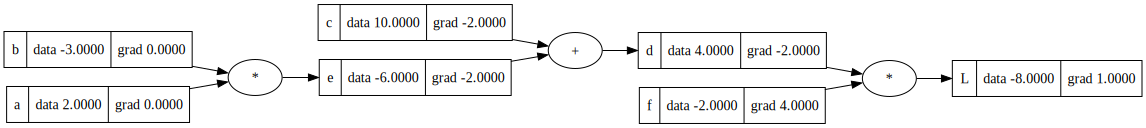

In [110]:
draw_dot(L)

node distributes derivative to all leaf nodes -> backwards flow

In [111]:
#for e
def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data 

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    e.data += h
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol()

-2.000000000000668


second application of chain rule: recurse backwards again; 

remaining node:

- have: $\frac{dL}{de}=-2$
- $\frac{dL}{da}=\frac{dL}{de}*\frac{de}{da}$

- $e=a*b$
- $\frac{de}{da}$?
- we get $\frac{de}{da}=b$, which is -3

In [126]:
#dL/da = dL/de * de/da = -2*b = -2*-3
a.grad = -2.0*-3.0 

#dL/db = dL/de * de/db = -2*a = -2*2
b.grad = -2.0*2.0 

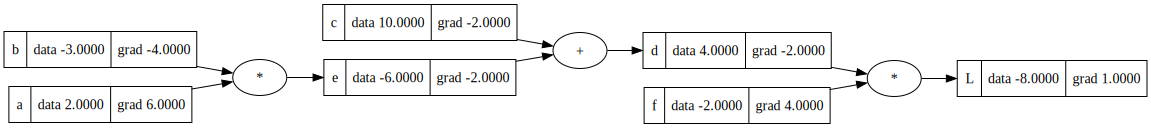

In [114]:
draw_dot(L)

In [115]:
#verify these grad values

#for a
def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data 

    a = Value(2.0, label="a")
    a.data += h
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000000227


In [117]:
#for b
def lol():

    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L1 = L.data 

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    b.data += h
    c = Value(10.0, label="c")
    e = a*b; e.label="e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d*f; L.label="L" 
    L2 = L.data

    print((L2 - L1)/h)

lol() #=-4

-3.9999999999995595


Recap: manual backprop by iterating through nodes one by one and finding local derivatives
- we know what the derivative of $L$ wrt to a little output 
- know derivatives within operation (local); have pointers to children nodes of this operation
- what happens: just go through and recurisvely multiply local derivatives

In [130]:
#below: leaf nodes (usu have more control over this)
#nudging in direction of gradient -- expect L to go up positively
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#forward pass
e = a*b 
d = e + c
L = d*f

print(L.data) #expect less negative value than -8


-7.286496


above example: shows one step of optimization

Now a more complex example: MLP

basic structure:
- some inputs $x$'s and synapse with weights $w$'s 
- synpase and inputs interact so many $x$'s times $w$'s 
- bias adds innate "trigger happy" mode
- put through activation function; squashing

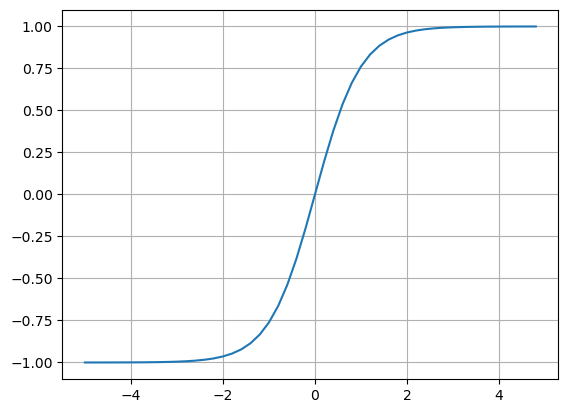

In [131]:
#ex: tanh fn
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

#at 0 we get exactly zero; fn goes up to 1 and plateaus; same w/ -1

essentially what happens in NN is activation fn applied to dot product of inputs and weights

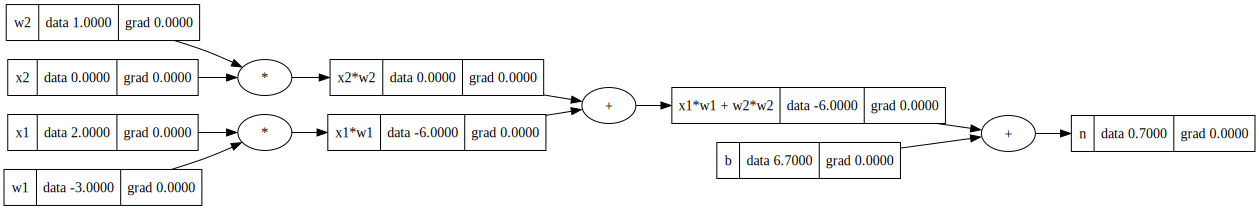

In [132]:
#inputs x1, x2 (2 dimensional neuron)
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights (synaptic strength of input)
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias
b = Value(6.7, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + w2*w2"
n = x1w1x2w2 + b; n.label = "n"

draw_dot(n)

take this through activation fn

- ex. $\tanh x$ is a hyperbolic fn (requires exponentiation)

$\tanh x = \frac{e^{2x}-1}{e^{2x}+1}$

In [136]:
#add exponentiation fn
class Value:
    """wraps+tracks a single scalar value; """
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children) #empty set if unspecified
        self._op = _op
        self.label = label
    
    def __repr__(self):
        """print out nicer looking expression; actual value of the object"""
        return f"Value(data={self.data})"
    
    #children of value obj created through addition should be self and other
    def __add__(self, other):
        """returns new value obj wrapping sum of the data float points"""
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        return out

as long as you know how to find the local derivative, can be as simple or complex of a fn as you want

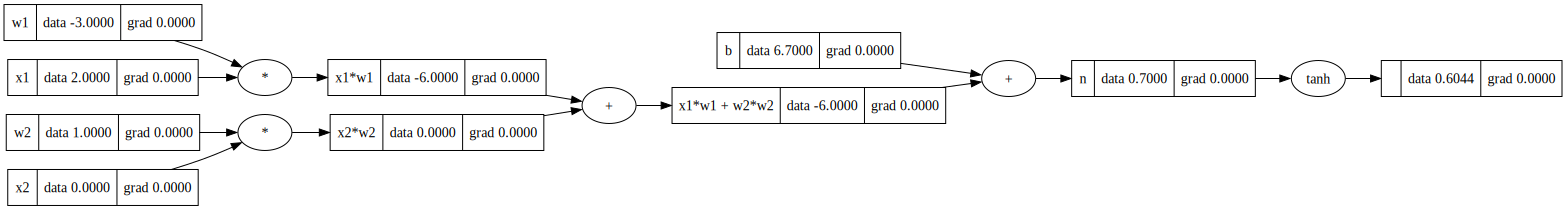

In [137]:
#inputs x1, x2 (2 dimensional neuron)
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

#weights (synaptic strength of input)
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#bias
b = Value(6.7, label="b")

#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + w2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh() #now that we have defined this method above in value class
draw_dot(o) #draw output

Now $\tanh$ is the micro-grad supported node as an operation+as long as we know its derivative, we can backpropagate. Currently (above) it's not squashing too much (from 0.7 to 0.6); try increasing bias to 8:

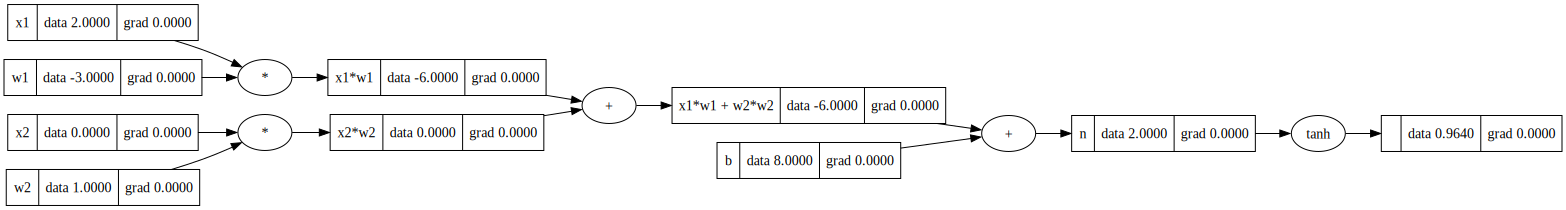

In [138]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#higher value for bias now
b = Value(8, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + w2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh() 
draw_dot(o) 

Above, we can see that it is being squashed more (from 2 to 0.96)

changing $b$ again (for simplicity's sake):

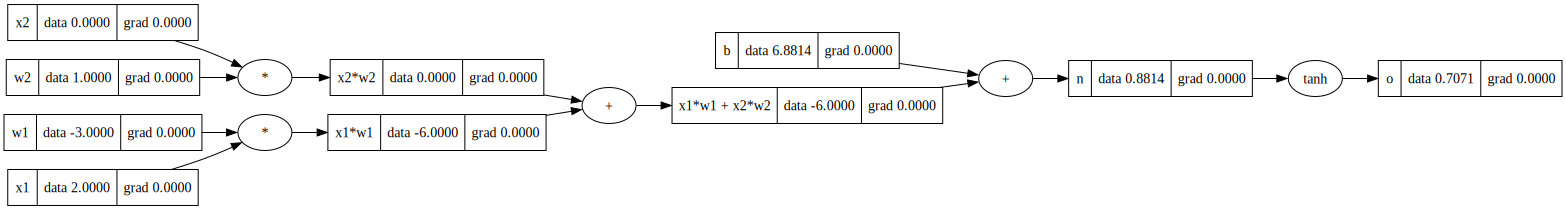

In [145]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

#for pretty numbers
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
draw_dot(o) 

Now for backprop, need to find derivative of $o$ wrt all the inputs

- what we care about: derivative wrt the weights $w_1$ and $w_2$ since those will be changing during optimization

"base case" = $\frac{do}{do} = 1$

In [146]:
#do/do = 1
o.grad = 1.0 

In [147]:
#do/dn = 1-tanh(n)^2 = 1-o^2
1 - o.data**2 #=0.5

0.4999999999999999

In [148]:
n.grad = 0.5

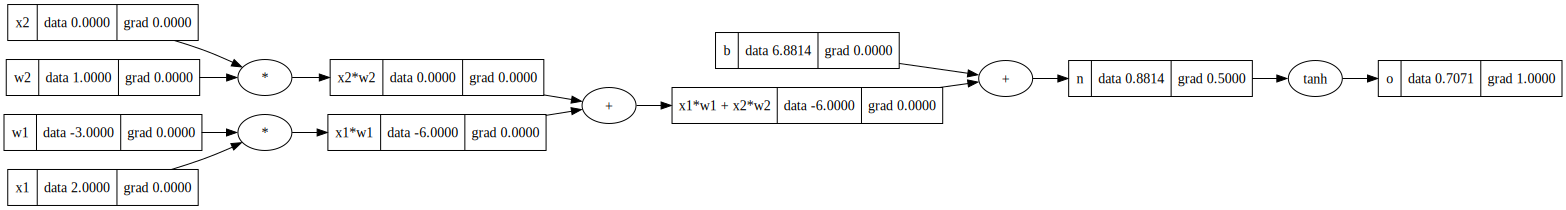

In [149]:
draw_dot(o)

Now to find derivative wrt plus operation ($b$ and $x_1w_1+x_2w_2$)

- recall: plus: just a distributor of gradient
- grad simply flows to both of these equally
- local derivative  of this operation is 1 for every one of its nodes (and multiply this by 0.5 to get 0.5)

In [150]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

Next plus operation:

In [151]:
x1w1.grad = 0.5
x2w2.grad = 0.5

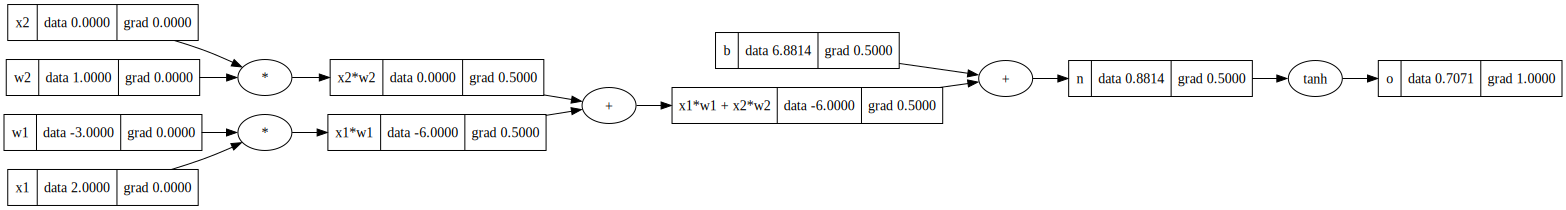

In [152]:
draw_dot(o)

Above -- What the derivative is telling us at every point in time along this graph is that if we want the output to increase, the influence on these expressions is positive on the output; both are positively contributing to the output (0.5 is positive)

Next:

- multiplication operation -- we know the derivative will just be the other term (multiplied by "previous" gradient of $x_2w_2$)
- first backpropagate to $x_2$ and $w_2$

In [153]:
x2.grad = w2.data*x2w2.grad #local piece of chain rule
w2.grad = x2.data*x2w2.grad

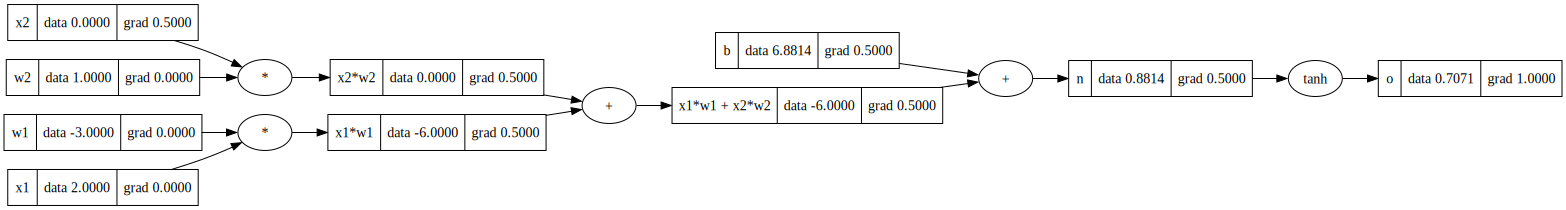

In [154]:
draw_dot(o)

Above: gradient on $w_2$ is 0 b/c $x_2$'s value (`x2.data`) is 0. Gradient on $x_2$ is 0.5 b/c $w_2$'s value is 1.

intuitively: derivative always tells usinfuence of this input on the output

- grad on $w_2$ will be 0 b/c if you wiggle it, output will not change either

Next: $x_1$ and $w_1$

In [155]:
#same idea:
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

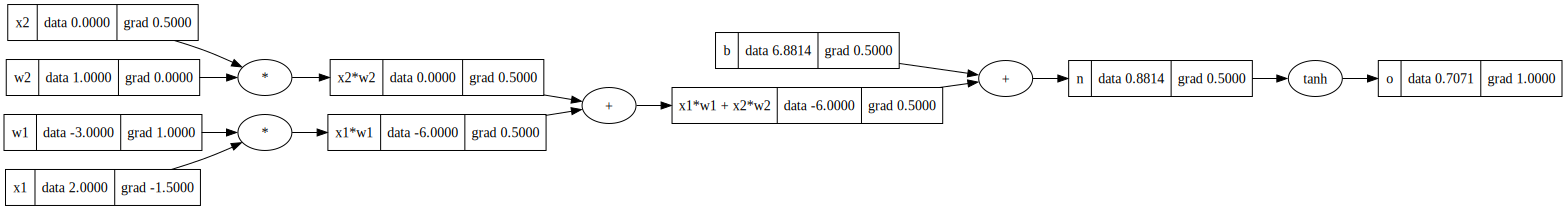

In [156]:
draw_dot(o)

Now have manually backpropagated across the whole graph -- what if we want neuron's output to **increase**?

Look at the weights:

- $w_2$ won't do anything (grad of 0)
- however, $w_1$ can be perturbed $\rightarrow$ output will go up if $w_1$ increases 

Start codifying this (no more manual backprop):

goal: take `out`'s grad and propagate it into `self`'s grad and `other`'s grad

**Addition:**

- `self.grad` = ?? and `other.grad` = ??
- take local derivative and multiply it by "global" derivative (derivative of final output of expression wrt `out` aka "previous upstream" derivative)

So we know that `self.grad` = 1 times grad of "global derivative" $\rightarrow$ `1.0*out.grad`

**Multiplication:**

- local derivative of `self` will be `other.data` multiplied by `out.grad`
- and vice versa

In [161]:
#store a function that does a little piece of the chain rule; chain output gradients into input gradients 
#by default, ._backward will not do anything (leaf node)
#if creating new Value object from an operation, need to specify what ._backward does

class Value:
    """wraps+tracks a single scalar value; """
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #grad initialized at 0 -- "base case"
        self._backward = lambda: None #in the case we are at a leaf node
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0*out.grad #derivative of itself will be 1
            other.grad = 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad = other.data*out.grad
            other.grad = self.data*out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

Call `._backward` in the right order:

- start with all grads at 0
- want to call backward, starting at output $o$

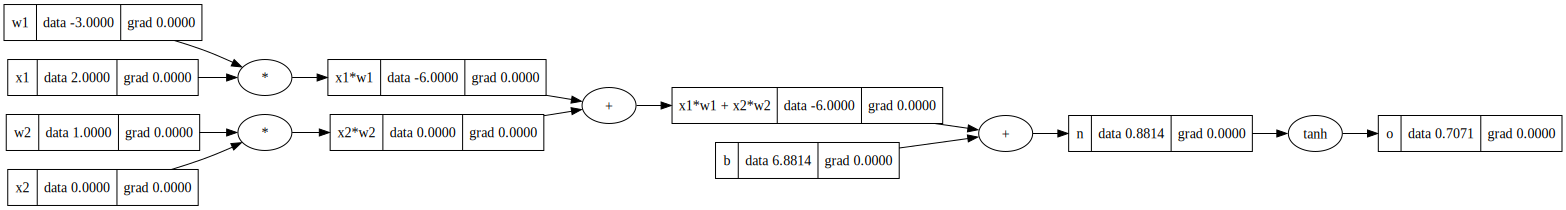

In [162]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
draw_dot(o) 

Need to set `o.grad` to 1 since it is initialized at 0

In [163]:
o.grad = 1.0

In [164]:
o._backward()

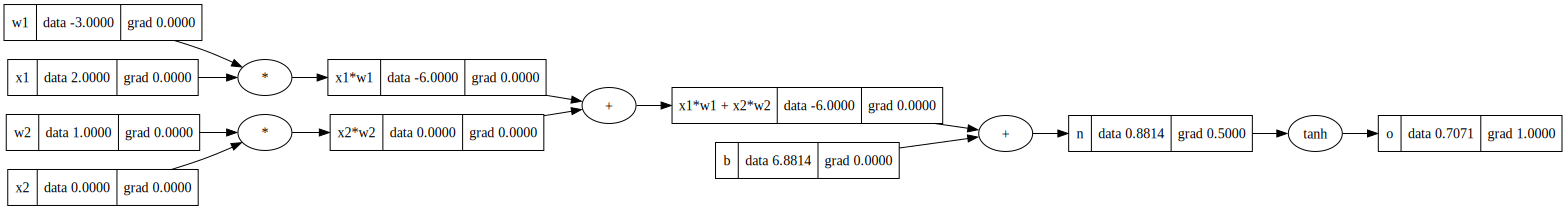

In [165]:
draw_dot(o)

Call `n._backward()`

In [166]:
n._backward()

and so on until we get to leaf nodes:

In [167]:
b._backward()

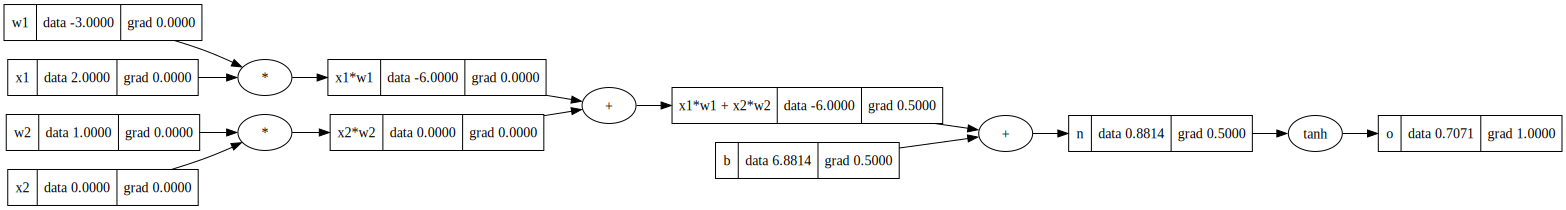

In [168]:
draw_dot(o)

In [169]:
x1w1x2w2._backward()

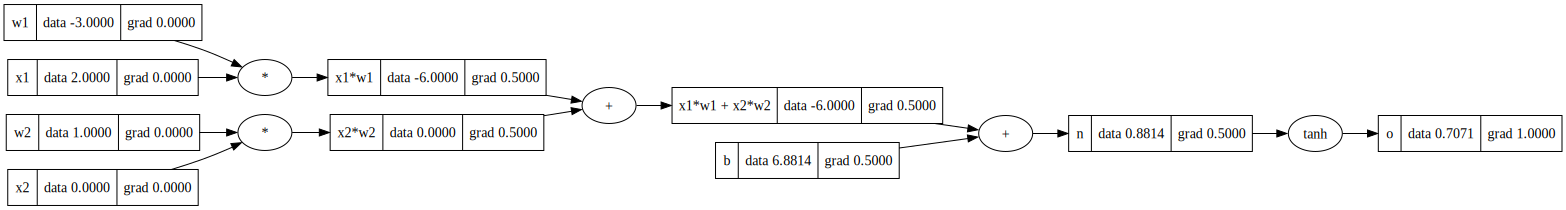

In [170]:
draw_dot(o)

In [171]:
x2w2._backward()
x1w1._backward()

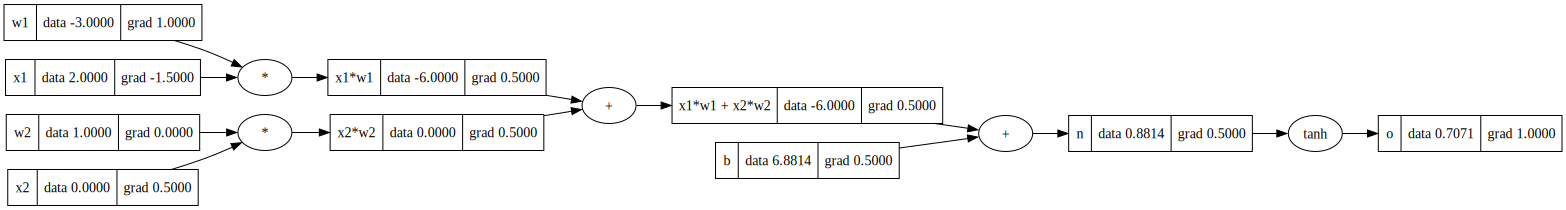

In [173]:
draw_dot(o)

Above: completed gradients (same answers as when we manually did it)

Now -- how to do this without having to manually call `._backward` each time?

trying to go backwards through an expression...

- i.e. don't want to call `._backward` for any node until everything after has been done
- to order this (provide the direction): **topological sort**

    - laying out of a graph st all edges only go one way
    - build topological order for propagation

Start by setting `o.grad = 1.0`

In [178]:
o.grad = 1.0 #base case

Build topological order

In [180]:
topo = []
visited_vertices = set() #set of visited vertices
def build_topo(vertex):
    if vertex not in visited_vertices:
        visited_vertices.add(vertex)
        for child in vertex._prev:
            build_topo(child)
        topo.append(vertex)

#start at some root node (eg o) and go through all of its children; then add itself

In [181]:
#invariant being maintained: o will only add itself to topo list after all of children have been processed
build_topo(o)

In [182]:
for vertex in reversed(topo): #reversed order, starting at root node
    vertex._backward()

Looking at expression graph again:

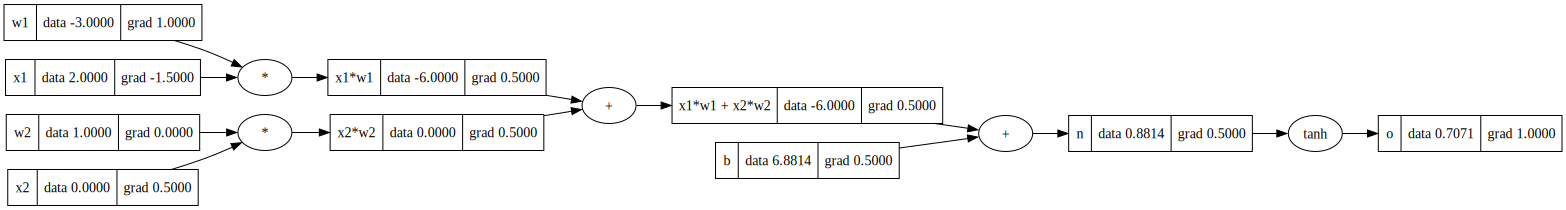

In [183]:
draw_dot(o)

Hiding the functionality; define as part of Value class

In [184]:

#defining an actual .backward method
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0*out.grad
            other.grad = 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad = other.data*out.grad
            other.grad = self.data*out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

In [186]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

In [187]:
o.backward()

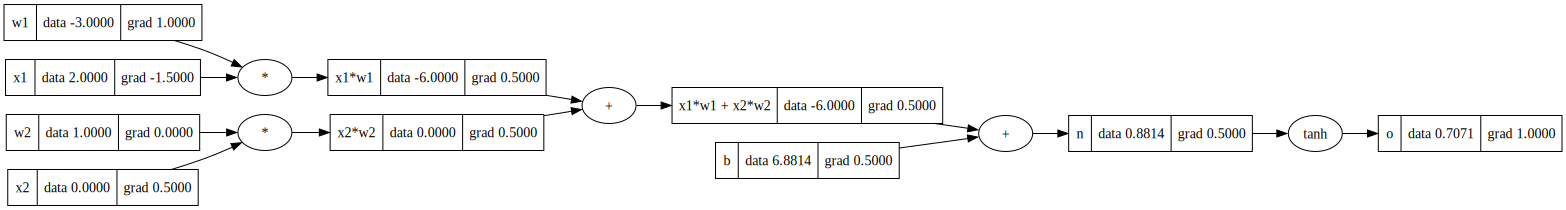

In [188]:
draw_dot(o) #completed without manually calling ._backward

Issue: calling $b = a+a$ will result in forward pass but incorrect gradient

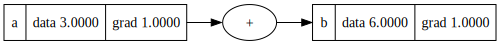

In [189]:
#ex. (wrong gradient)
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

grad of $b$ wrt $a$ should be 2 (since $b=2a$), not 1.

what's happening here:

- call `.backward()` on $b$
- $b$ is the sum of $a$ and $a$, so we end up setting `self.grad = 1.0*out.grad` and `other.grad = 1.0*out.grad`
- end up setting gradient = 1, then overriding it and setting it to 1 again (since $a$'s are the same) $\rightarrow$ our grad will stay at 1

another example:

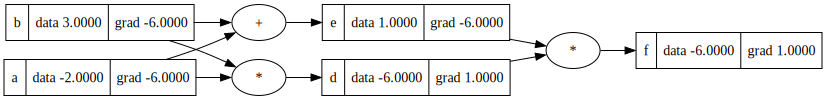

In [190]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a*b; d.label = "d"
e = a+b; e.label = "e"
f = d*e; f.label = "f"

f.backward()
draw_dot(f)

Above, gradients are incorrect b/c we run into problems once we use the same variable(s) multiple times (ends up overwriting the gradients)

solution: multivariate way of conducting the chain rule; accumulate gradients using `+=`

In [192]:

#make sure grads accumulate in case we reuse any variables in our expressions
#instead of overwriting "previous" gradient, it adds it on top
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

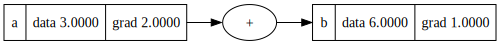

In [193]:
#ex. (now correct)
a = Value(3.0, label="a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)

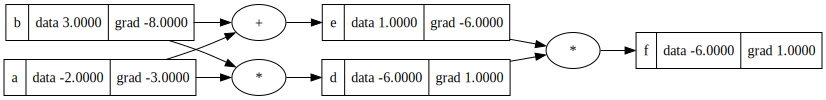

In [194]:
#another example (now correct)
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a*b; d.label = "d"
e = a+b; e.label = "e"
f = d*e; f.label = "f"

f.backward()
draw_dot(f)

Broke down $\tanh$ into its explicit atoms; now can try breaking it down into a fn of $x$

Currently can't add constant to a value object (Python is trying to access `1.data` but that dne since 1 is just an integer)

In [195]:
a = Value(2.0)
a+1

AttributeError: 'int' object has no attribute 'data'

In [196]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        #let other alone if it is another Value objet; but if it's an integer or float, wrap it into a value object so we can add them
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

In [197]:
a = Value(2.0)
a + 1

Value(data=3.0)

now do same for multiplication

In [198]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        #allows us to multiply by a constant without it being a value object originally
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

In [199]:
a = Value(2.0)
a*2

Value(data=4.0)

In [200]:
#however this won't work:
2*a 

#under the hood:
#2.__mul__(a) which won't work

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

solution: define `__rmul__` method; will check if 

In [205]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out
    
    #swaps order of operands
    def __rmul__(self, other): #other*self
        return self*other
    
    def __radd__(self, other): #other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

In [203]:
a = Value(2.0)
2*a 

Value(data=4.0)

In [206]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [207]:
#returns TypeError
a = Value(2.0)
b = Value(4.0)
a/b

TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

Implementing something more powerful than division

- want `a/b` to give us 0.5
- **reshuffle** since dividing $a$ by $b$ is the same as multiplying $a$ and $b^{-1}$

operation $x^k$ for some constant $k$; as a special case, $k=-1$ for division

- define `.__truediv__` and `.__pow__`

In [209]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other): #defining powers
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other - 1))*out.grad #just chain rule again
        out._backward = _backward

        return out
    
    def __rmul__(self, other): #other*self
        return self*other
    
    def __radd__(self, other): #other + self
        return self + other
    
    def __truediv__(self, other): #self/other
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

In [210]:
a = Value(2.0)
b = Value(4.0)
a/b #now shows what we want -- forward pass works

Value(data=0.5)

define subtraction operation via implementation of addition of a negation; to implement negation, multiplication by -1 (using things we've already built)

In [212]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None 
        self._prev = set(_children) 
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other - 1))*out.grad 
        out._backward = _backward

        return out
    
    def __neg__(self): #-self; implement via multiplication
        return self*-1

    def __sub__(self, other): #self-other; implement via addition of negation
        return self + (-other)
    
    def __rmul__(self, other): #other*self
        return self*other
    
    def __radd__(self, other): #other + self
        return self + other
    
    def __truediv__(self, other): #self/other
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
    
        return out
    
    def backward(self):
        topo = []
        visited_vertices = set()
        def build_topo(vertex):
            if vertex not in visited_vertices:
                visited_vertices.add(vertex)
                for child in vertex._prev:
                    build_topo(child)
                topo.append(vertex)
        build_topo(self)

        self.grad = 1.0
        for vertex in reversed(topo):
            vertex._backward()

In [213]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()

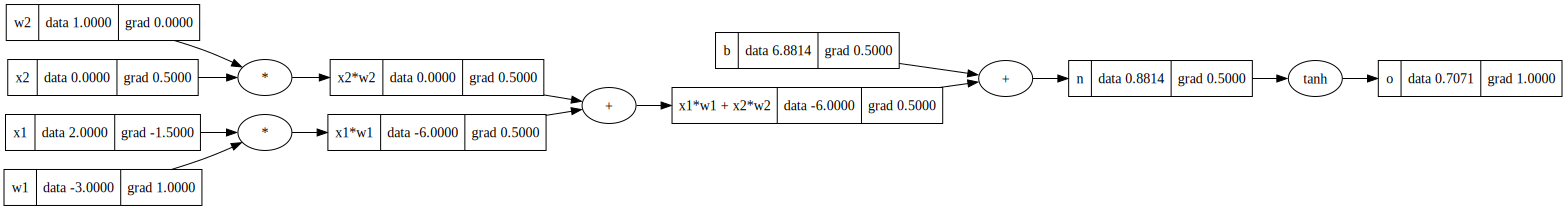

In [214]:
draw_dot(o) 

now take this and break $\tanh$ down into just a fn of $x$

In [215]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# -----
e = (2*n).exp()
o = (e-1)/(e+1)
# -----
o.label = "o"
o.backward()

#expect to see a much longer graph now that tanh has been broken up into multiple operations
#forward and backward pass should work in the same way

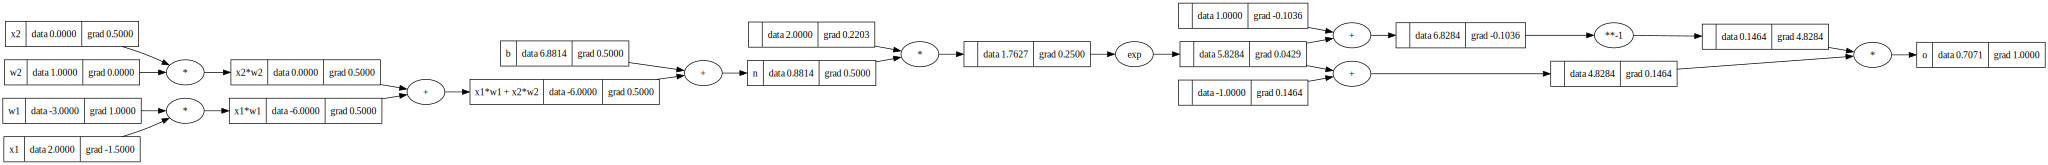

In [216]:
draw_dot(o)

Upshot: the level at which you implement your operations is up to you -- can do tiny expressions or more specific fns like $\tanh$

**Doing this with modern NN libraries** (such as PyTorch)

- previously: using micrograd, a **scalar-valued engine**
- Tensors: $n$-dimensional arrays of scalars

In [218]:
#ex: create tensor (2x3 array of scalars in a single compact representation)
Tensor([[1, 2, 3], [4, 5, 6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [219]:
Tensor([[1, 2, 3], [4, 5, 6]]).shape #2x3

torch.Size([2, 3])

In [220]:
#tensor with only a single element -> cast it to be double so it is float64 instead of float32 (default in python)
Tensor([2.0]).double().dtype #similar to Value(2.0)

torch.float64

Default: these are leaf nodes -- Python assumes all tensors don't need gradients -- here, specify that `requires_grad = True`

- Usually don't need gradients for leaf nodes (more efficient)

Once we define our values, can perform arithmetic like we did with micrograd; get back a tensor with `.data` attribute and `.grad` attribute

- one difference: need to take `.item()` of `.data` or `.grad` attribute in order to strip out the single-element tensor and just return the element

In [223]:
#construct scalar-valued one element tensors that require gradients
x1 = Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = Tensor([1.0]).double()                ; w2.requires_grad = True
b = Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

#gradients
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Can do lots of these operations in parallel on all these tensors $\rightarrow$ high efficiency of PyTorch

Building NNs

- starting with 1 neuron

In [226]:
class Neuron:
  
    #constructor: takes # inputs to this neuron as a parameter
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias

    #w*x + b (dot product)
    def __call__(self, x):
        return 0.0 #temporary 

#what does __call__ do?
#ex:

x = [2.0, 3.0]
n = Neuron(2) #2d neuron
#feed 2 numbers into neuron to get output:
n(x) #under the hood: python returns __call__

0.0

To do forward pass of this neuron:

- multiply all elements of $w$ by all elements of $x$ pairwise 

making this more efficient:

- `sum()` takes in an optional parameter `start` that by default is -- added to sum 
- can put `self.b` there instead

In [227]:
class Neuron:
  
    #constructor: takes # inputs to this neuron as a parameter
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias

    #w*x + b (dot product)
    def __call__(self, x):
        #takes 2 iterators+creates new iterator that iterates over tuples of corresponding entries
        #activation
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

Now define a new class: **layer** of neurons

- evaluated independently (not connected to each other) but all are fully connected to input

In [228]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias

    def __call__(self, x):
        """w*x + b"""
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

In [229]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9982415984044078)

In [231]:
x = [2.0, 3.0]
n = Layer(2, 3) #2 inputs, 3 outputs
n(x)

[Value(data=0.9735622174316104),
 Value(data=-0.9999103412811101),
 Value(data=-0.9759477445597775)]

Now define an entire **MLP**

Layers feed into each other **sequentially**

In [232]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias

    def __call__(self, x):
        """w*x + b"""
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs

#instead of taking a single nout (# of neurons in a singl layer) want a list nouts with sizes of all layers we want in our mlp
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  #call sequentially
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [234]:
#forward pass in an MLP
x = [2.0, 3.0, -1.0] #in puts
n = MLP(3, [4, 4, 1]) #3 inputs, 2 layers of 4 neurons, 1 output
n(x)

[Value(data=-0.41001114452646087)]

Make it look prettier -- since the layer class will always return a call with a list...

In [272]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias

    def __call__(self, x):
        """w*x + b"""
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
  
    def __init__(self, nin, nout):
      self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs)==1 else outs #allows us to just get a single value at the last layer

class MLP:
  
    def __init__(self, nin, nouts):
      sz = [nin] + nouts
      self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  #call sequentially
    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      return x

In [273]:
x = [2.0, 3.0, -1.0] 
n = MLP(3, [4, 4, 1]) 
n(x)

Value(data=0.39485893381196424)

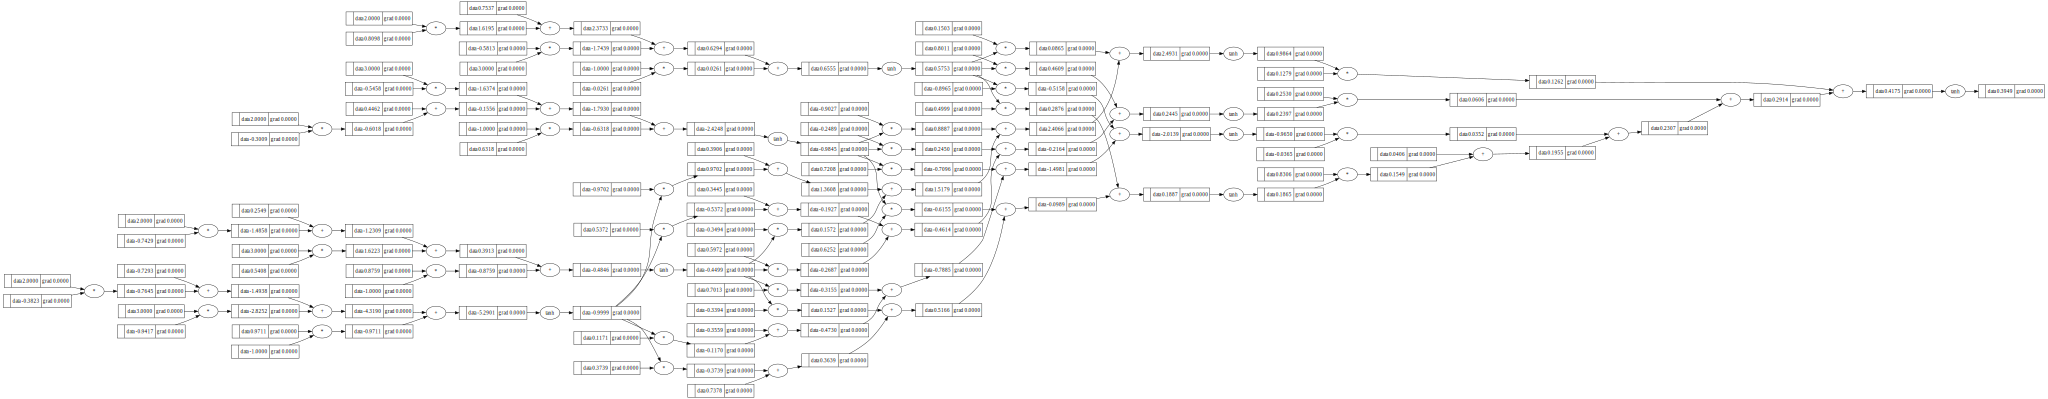

In [274]:
draw_dot(n(x))

Can backpropagate through all of this into the weights using micrograd

In [275]:
#binary classifier NN

#4 possible inputs into NN
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

#4 desired targets
ys = [1.0, -1.0, -1.0, 1.0] 

In [276]:
#outputs of NN on these 4 examples:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.39485893381196424),
 Value(data=0.7619356815122641),
 Value(data=0.6342471968220058),
 Value(data=0.5609407605888754)]

output:

- [Value(data=0.39485893381196424),
 Value(data=0.7619356815122641),
 Value(data=0.6342471968220058),
 Value(data=0.5609407605888754)]
- want this to be closer to 1, -1, -1, 1

how to tune the weights to better predict desired targets?

- **loss:** calculate a single number that measures the total performance of your NN; measures how well your model is performing

Ex. MSE

In [277]:
#pair up ground truths and predictions
#final loss: sum of all these numbers:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.334149971806139)

How to minimize loss

In [278]:
loss.backward() 

In [279]:
n.layers[0].neurons[0].w[0].grad #can look at grad for a single weight

0.5004820034715549

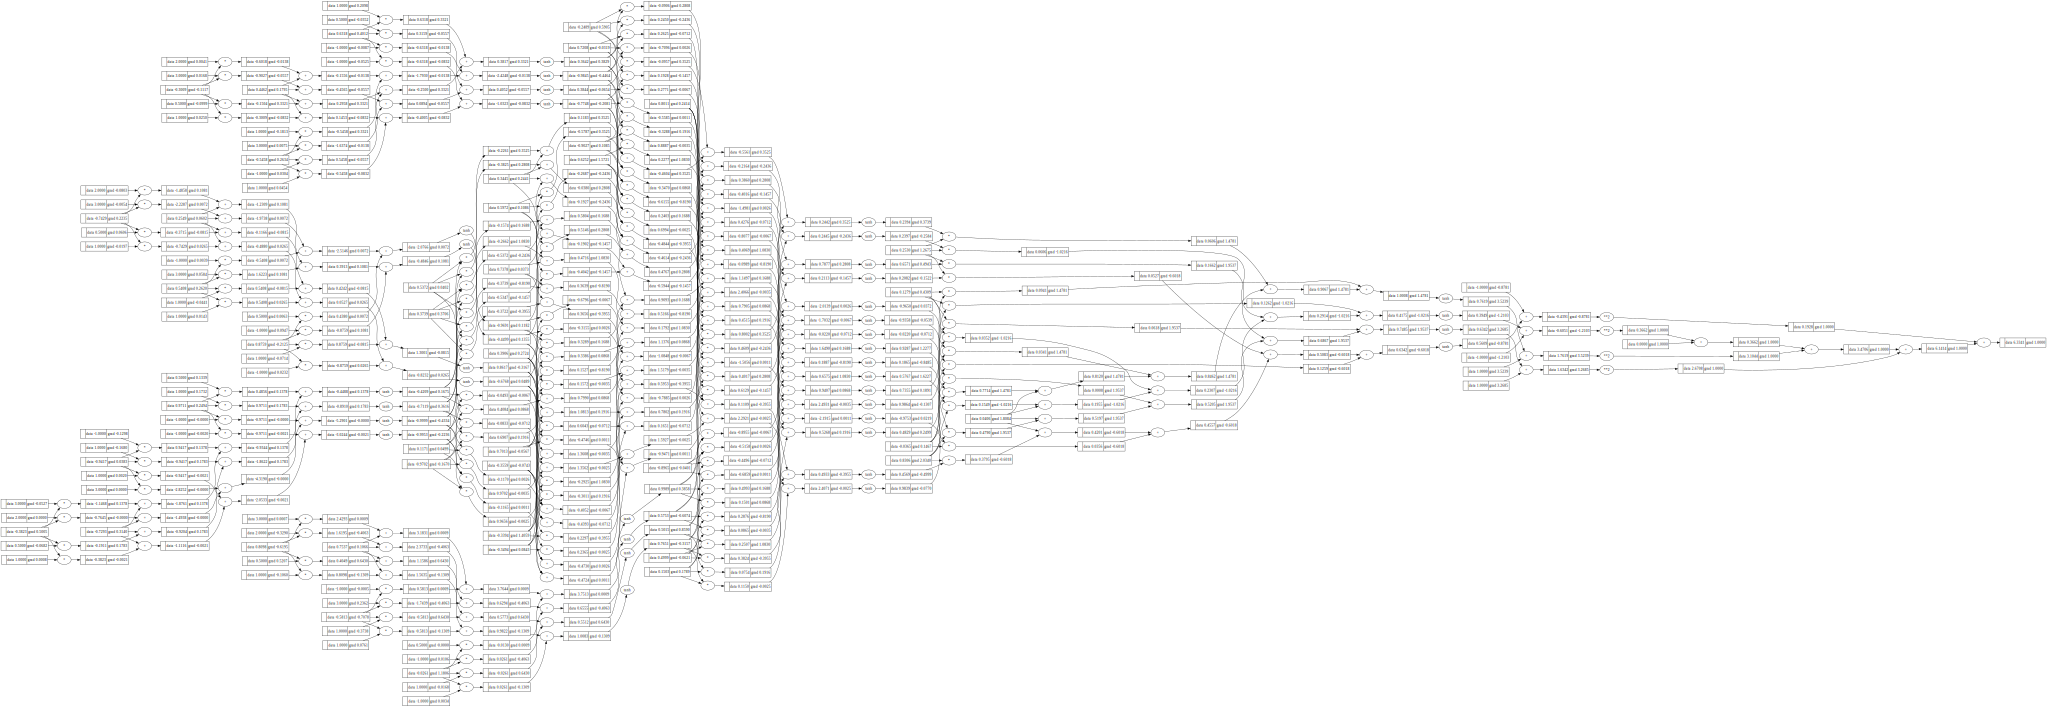

In [280]:
draw_dot(loss)

backprop goes through and finds grad for all inputs

- input scalars $x$'s are probably not changeable though
- weights more important 

Want to gather parameters of net so we can operate on all of them simultaneously+nudge a tiny amount

In [281]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias

    def __call__(self, x):
        """w*x + b"""
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
       """returns a list of all ws and bs"""
       return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
      self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs)==1 else outs #allows us to just get a single value at the last layer
    
    def parameters(self):
        """take params of neuron and add to this list"""
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
        #same thing:
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
  
    def __init__(self, nin, nouts):
      sz = [nin] + nouts
      self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
      for layer in self.layers:
        x = layer(x)
      return x
    
    def parameters(self):
        """take params of layer and add to this list"""
        return [p for layer in self.layers for p in layer.parameters()]

In [282]:
x = [2.0, 3.0, -1.0] 
n = MLP(3, [4, 4, 1]) 
n(x)

Value(data=0.7919463881036437)

In [283]:
n.parameters() #returns all weights and biases of your NN

[Value(data=-0.9801197195122864),
 Value(data=0.24559000590076874),
 Value(data=-0.2714268698568405),
 Value(data=0.6347365825489222),
 Value(data=0.7650871947814988),
 Value(data=0.7868093832274312),
 Value(data=0.2890033736061921),
 Value(data=0.8639412113809737),
 Value(data=-0.5085653462266857),
 Value(data=-0.5128056586030709),
 Value(data=0.1429648228800824),
 Value(data=-0.14770052696960634),
 Value(data=-0.03518311762506121),
 Value(data=-0.4240384732810216),
 Value(data=0.1686276505601787),
 Value(data=0.38380762005421376),
 Value(data=0.6831318842909966),
 Value(data=-0.9176880357284365),
 Value(data=0.21449731161504904),
 Value(data=-0.25433090170840167),
 Value(data=-0.5611664399444614),
 Value(data=-0.883697849628027),
 Value(data=-0.21990344721946786),
 Value(data=-0.36053666423910835),
 Value(data=0.9136541471667761),
 Value(data=-0.6601793564176934),
 Value(data=0.7147198357391136),
 Value(data=-0.12156235150511185),
 Value(data=0.045127533135210784),
 Value(data=0.2833

In [284]:
len(n.parameters()) #41 parameters

41

In [285]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [286]:
ypred = [n(x) for x in xs] #forward
ypred

[Value(data=0.7919463881036437),
 Value(data=0.7201916145303128),
 Value(data=0.4533527289748783),
 Value(data=0.4768599362321087)]

In [288]:
#loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.388255177261324)

In [289]:
loss.backward()

In [290]:
n.layers[0].neurons[0].w[0].grad

-0.12471425161578942

In [291]:
n.layers[0].neurons[0].w[0].data

-0.9801197195122864

iterate over 41 parameters and change `p.data` slightly based on information (tiny update)

gradient in gradient descent: think of as vector pointing in direction of increased loss

In [292]:
for p in n.parameters():
    p.data += -0.01*p.grad #step size = 0.01; negative to decrease loss

In [293]:
n.layers[0].neurons[0].w[0].data

-0.9788725769961285

In [294]:
#recalculate forward pass -- compare to 5.388255177261324
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss #4.81465461280663 (this is a bit lower than before)

Value(data=4.81465461280663)

Now that we did forward pass, can do backward pass:

- call `loss.backward()`
- step size update

In [295]:
#backward
loss.backward()

In [296]:
#update
for p in n.parameters():
    p.data += -0.01*p.grad

forward pass again... (with step size)

In [297]:
ypred = [n(x) for x in xs] #forward
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #new loss

In [298]:
loss #lower than before

Value(data=3.7029846198524257)

backward again... and so on

Just iteratively doing forward pass, backward pass, update

In [299]:
ypred

[Value(data=0.6132503547438835),
 Value(data=0.38573925521177194),
 Value(data=-0.011235826181103867),
 Value(data=0.1903819067708203)]

In [ ]:
#do this iteratively:

for k in range(20):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #mse
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
  
    #simple sgd update
    for p in n.parameters():
        p.data += -0.1 * p.grad
  
    print(k, loss.data)

Can increase step size to make this go faster but beware of overstepping

**Upshot**

- NN = mathematical expressions that take input as data (weights+parameters)
- mathematical expression for forward pass, followed by loss function 
- loss fn tries to measure accuracy of predictions (low if net is behaving well)
- backward loss using backpropagation to get gradient
- know how to tune parameters to decrease loss locally
- iterate that process many times (**gradient descent**)

**Other notes:**

- previously just had a tiny dataset of 4 examples, but in the case where your data is a million examples, pick out a random subset (**batch**) and only process the batch through forward-backward-update (don't need to forward the entire training set)
- can make your own custom functions using `class <fn_name>(torch.autograd.Function)` as long as you can define forward (and know the local derivatives), PyTorch can backpropagate through your fn